In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os
import glob
import re
import matplotlib.pyplot as plt
from scipy import signal
import statsmodels.api as sm
import datetime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Reading files
XTrain_path = r'/content/drive/MyDrive/CSCI5622-group_project/project milestone 4/code/XTrain.csv'
XTrain_path_PM25 = r'/content/drive/MyDrive/CSCI5622-group_project/project milestone 4/code/XTrain_PM25.csv'
yTrain_path = r'/content/drive/MyDrive/CSCI5622-group_project/project milestone 4/code/yTrain.csv'
XTest_path = r'/content/drive/MyDrive/CSCI5622-group_project/project milestone 4/code/XTest.csv'
XTest_path_PM25 = r'/content/drive/MyDrive/CSCI5622-group_project/project milestone 4/code/XTest_PM25.csv'
yTest_path = r'/content/drive/MyDrive/CSCI5622-group_project/project milestone 4/code/yTest.csv'

XTrain = pd.read_csv(XTrain_path, on_bad_lines='skip')
XTrain_PM25 = pd.read_csv(XTrain_path_PM25, on_bad_lines='skip')
yTrain = pd.read_csv(yTrain_path, on_bad_lines='skip')

XTest = pd.read_csv(XTest_path, on_bad_lines='skip')
XTest_PM25 = pd.read_csv(XTest_path_PM25, on_bad_lines='skip')
yTest = pd.read_csv(yTest_path, on_bad_lines='skip')

print('Shape of XTrain: ' + str(XTrain.shape) + ' -> XTrain dataset for fitting the main models')
print('Shape of XTrain_PM25: ' + str(XTrain_PM25.shape) + " -> XTrain with target station's PM25 value for fitting the base1/base2 models")
print('Shape of yTrain: ' + str(yTrain.shape) + ' -> yTrain dataset for fitting the main/base1/base2 models')

print('Shape of XTest: ' + str(XTest.shape) + ' -> XTest dataset for testing the main models')
print('Shape of XTest_PM25: ' + str(XTest_PM25.shape) + " -> XTest with target stations's PM25 value for testing the base1/base2 models")
print('Shape of yTest: ' + str(yTest.shape) + ' -> yTest dataset for testing the moain/base1/base2 models')

Shape of XTrain: (34890, 12) -> XTrain dataset for fitting the main models
Shape of XTrain_PM25: (34890, 13) -> XTrain with target station's PM25 value for fitting the base1/base2 models
Shape of yTrain: (34723, 2) -> yTrain dataset for fitting the main/base1/base2 models
Shape of XTest: (8730, 12) -> XTest dataset for testing the main models
Shape of XTest_PM25: (8730, 13) -> XTest with target stations's PM25 value for testing the base1/base2 models
Shape of yTest: (8563, 2) -> yTest dataset for testing the moain/base1/base2 models


In [ ]:
# Clipping PM25 data
# Small subset of PM25 value is much higher than average
# Clip PM25 values to 0~100 (Over 100 is very poor according to the EPA)
columns=['Upland_PM25', 'Lake_Elsinore_PM25', 'Temecula_PM25', 'Banning_PM25', 'Central_San_Bernardino_PM25']
columns2 = ['PM25', 'Upland_PM25', 'Lake_Elsinore_PM25', 'Temecula_PM25', 'Banning_PM25', 'Central_San_Bernardino_PM25']

XTrain[columns] = np.clip(XTrain[columns], a_min=0, a_max=100)
XTrain_PM25[columns2] = np.clip(XTrain_PM25[columns2], a_min=0, a_max=100)
XTest[columns] = np.clip(XTest[columns], a_min=0, a_max=100)
XTest_PM25[columns2] = np.clip(XTest_PM25[columns2], a_min=0, a_max=100)

yTrain['PM25'] = np.clip(yTrain['PM25'], a_min=0, a_max=100)
yTest['PM25'] = np.clip(yTest['PM25'], a_min=0, a_max=100)

In [ ]:
XTrain.describe().T

,count,mean,std,min,25%,50%,75%,max
CO,34890.0,1.125621,0.243682,1.0,1.000000,1.000000,1.148500,3.56
O3,34890.0,32.708154,23.899174,0.0,12.000000,31.000000,47.000000,146.00
WD,34890.0,202.426334,85.694023,0.0,137.000000,239.000000,263.420307,359.80
NO2,34890.0,13.502451,9.848236,0.0,6.000000,10.000000,18.000000,66.00
T,34890.0,66.354311,13.861365,0.0,57.000000,65.000000,75.000000,114.60
WS,34890.0,4.153727,4.047939,0.0,1.000000,3.000000,6.000000,29.00
Upland_PM25,34890.0,18.329378,10.561930,0.0,11.000000,16.568323,24.000000,100.00
Lake_Elsinore_PM25,34890.0,12.517670,7.391629,0.0,7.000000,11.303492,16.000000,100.00
Temecula_PM25,34890.0,10.552895,6.002895,0.0,6.500000,10.000000,13.000000,100.00
Banning_PM25,34890.0,14.631298,7.710248,0.0,9.200347,13.000000,19.000000,100.00


In [ ]:
XTrain_PM25.describe().T

,count,mean,std,min,25%,50%,75%,max
CO,34890.0,1.125621,0.243682,1.0,1.000000,1.000000,1.148500,3.56
O3,34890.0,32.708154,23.899174,0.0,12.000000,31.000000,47.000000,146.00
WD,34890.0,202.426334,85.694023,0.0,137.000000,239.000000,263.420307,359.80
NO2,34890.0,13.502451,9.848236,0.0,6.000000,10.000000,18.000000,66.00
T,34890.0,66.354311,13.861365,0.0,57.000000,65.000000,75.000000,114.60
PM25,34890.0,20.059903,10.832952,0.0,13.000000,18.000000,25.000000,100.00
WS,34890.0,4.153727,4.047939,0.0,1.000000,3.000000,6.000000,29.00
Upland_PM25,34890.0,18.329378,10.561930,0.0,11.000000,16.568323,24.000000,100.00
Lake_Elsinore_PM25,34890.0,12.517670,7.391629,0.0,7.000000,11.303492,16.000000,100.00
Temecula_PM25,34890.0,10.552895,6.002895,0.0,6.500000,10.000000,13.000000,100.00


In [ ]:
XTest.describe().T

,count,mean,std,min,25%,50%,75%,max
CO,8730.0,1.029553,0.166577,1.0,1.0,1.0,1.000000,2.0
O3,8730.0,31.682532,22.504869,1.0,12.0,31.0,45.000000,117.0
WD,8730.0,210.939404,83.393381,0.0,157.0,248.0,268.000000,359.0
NO2,8730.0,12.281901,9.257125,0.0,5.0,9.0,18.000000,54.0
T,8730.0,64.957388,13.295983,33.0,55.0,64.0,73.000000,103.0
WS,8730.0,3.757617,3.904044,0.0,1.0,3.0,5.325758,30.0
Upland_PM25,8730.0,16.502879,10.173534,0.0,10.0,15.0,21.000000,100.0
Lake_Elsinore_PM25,8730.0,11.183734,5.513087,0.0,7.0,11.0,14.000000,48.0
Temecula_PM25,8730.0,10.484651,5.256569,0.0,7.0,10.0,13.000000,100.0
Banning_PM25,8730.0,16.403608,7.699923,0.0,11.0,15.0,20.000000,100.0


In [ ]:
XTest_PM25.describe().T

,count,mean,std,min,25%,50%,75%,max
CO,8730.0,1.029553,0.166577,1.0,1.0,1.0,1.000000,2.0
O3,8730.0,31.682532,22.504869,1.0,12.0,31.0,45.000000,117.0
WD,8730.0,210.939404,83.393381,0.0,157.0,248.0,268.000000,359.0
NO2,8730.0,12.281901,9.257125,0.0,5.0,9.0,18.000000,54.0
T,8730.0,64.957388,13.295983,33.0,55.0,64.0,73.000000,103.0
PM25,8730.0,20.970619,10.695397,1.0,14.0,19.0,25.000000,100.0
WS,8730.0,3.757617,3.904044,0.0,1.0,3.0,5.325758,30.0
Upland_PM25,8730.0,16.502879,10.173534,0.0,10.0,15.0,21.000000,100.0
Lake_Elsinore_PM25,8730.0,11.183734,5.513087,0.0,7.0,11.0,14.000000,48.0
Temecula_PM25,8730.0,10.484651,5.256569,0.0,7.0,10.0,13.000000,100.0


In [ ]:
# Standardization
# Standardize the Training data for each column
from sklearn.preprocessing import StandardScaler

ori_col = [column for column in XTrain.columns if column!='Date Time']
ori_col_PM25 = [column for column in XTrain_PM25.columns if column!='Date Time']

scaler_train = StandardScaler()
scaler_trainPM25 = StandardScaler()

scaler_train.fit(XTrain[ori_col])
XTrain_std = scaler_train.transform(XTrain[ori_col])
XTest_std = scaler_train.transform(XTest[ori_col])

scaler_trainPM25.fit(XTrain_PM25[ori_col_PM25])
XTrain_PM25_std = scaler_trainPM25.transform(XTrain_PM25[ori_col_PM25])
XTest_PM25_std = scaler_trainPM25.transform(XTest_PM25[ori_col_PM25])

In [ ]:
pd.DataFrame(XTrain_std).describe().T

,count,mean,std,min,25%,50%,75%,max
0,34890.0,-2.003938e-16,1.000014,-0.515519,-0.515519,-0.515519,0.093890,9.990132
1,34890.0,5.213498e-17,1.000014,-1.368609,-0.866492,-0.071474,0.598014,4.740476
2,34890.0,1.466296e-16,1.000014,-2.362233,-0.763499,0.426800,0.711775,1.836487
3,34890.0,4.561811e-17,1.000014,-1.371072,-0.761817,-0.355648,0.456692,5.330732
4,34890.0,6.712378e-16,1.000014,-4.787066,-0.674857,-0.097705,0.623735,3.480637
5,34890.0,6.191029e-17,1.000014,-1.026149,-0.779106,-0.285020,0.456108,6.138094
6,34890.0,3.258436e-18,1.000014,-1.735444,-0.693953,-0.166738,0.536900,7.732658
7,34890.0,0.000000e+00,1.000014,-1.693517,-0.746486,-0.164266,0.471125,11.835495
8,34890.0,6.842716e-17,1.000014,-1.757993,-0.675166,-0.092106,0.407660,14.900874
9,34890.0,9.286543e-17,1.000014,-1.897670,-0.704391,-0.211578,0.566618,11.072267


In [ ]:
pd.DataFrame(XTest_std).describe().T

,count,mean,std,min,25%,50%,75%,max
0,8730.0,-0.394239,0.683595,-0.515519,-0.515519,-0.515519,-0.515519,3.588251
1,8730.0,-0.042915,0.941672,-1.326766,-0.866492,-0.071474,0.514328,3.527028
2,8730.0,0.099344,0.973167,-2.362233,-0.530107,0.531826,0.765218,1.827151
3,8730.0,-0.123938,0.939992,-1.371072,-0.863360,-0.457190,0.456692,4.112222
4,8730.0,-0.100780,0.959225,-2.406313,-0.819145,-0.169849,0.479447,2.643767
5,8730.0,-0.097856,0.964466,-1.026149,-0.779106,-0.285020,0.289542,6.385137
6,8730.0,-0.172935,0.963241,-1.735444,-0.788634,-0.315229,0.252857,7.732658
7,8730.0,-0.180468,0.745866,-1.693517,-0.746486,-0.205326,0.200545,4.800409
8,8730.0,-0.011369,0.875685,-1.757993,-0.591872,-0.092106,0.407660,14.900874
9,8730.0,0.229867,0.998675,-1.897670,-0.470977,0.047820,0.696317,11.072267


In [ ]:
pd.DataFrame(XTrain_PM25_std).describe().T

,count,mean,std,min,25%,50%,75%,max
0,34890.0,-2.003938e-16,1.000014,-0.515519,-0.515519,-0.515519,0.093890,9.990132
1,34890.0,5.213498e-17,1.000014,-1.368609,-0.866492,-0.071474,0.598014,4.740476
2,34890.0,1.466296e-16,1.000014,-2.362233,-0.763499,0.426800,0.711775,1.836487
3,34890.0,4.561811e-17,1.000014,-1.371072,-0.761817,-0.355648,0.456692,5.330732
4,34890.0,6.712378e-16,1.000014,-4.787066,-0.674857,-0.097705,0.623735,3.480637
5,34890.0,-1.466296e-16,1.000014,-1.851775,-0.651716,-0.190154,0.456032,7.379452
6,34890.0,6.191029e-17,1.000014,-1.026149,-0.779106,-0.285020,0.456108,6.138094
7,34890.0,3.258436e-18,1.000014,-1.735444,-0.693953,-0.166738,0.536900,7.732658
8,34890.0,0.000000e+00,1.000014,-1.693517,-0.746486,-0.164266,0.471125,11.835495
9,34890.0,6.842716e-17,1.000014,-1.757993,-0.675166,-0.092106,0.407660,14.900874


In [ ]:
pd.DataFrame(XTest_PM25_std).describe().T

,count,mean,std,min,25%,50%,75%,max
0,8730.0,-0.394239,0.683595,-0.515519,-0.515519,-0.515519,-0.515519,3.588251
1,8730.0,-0.042915,0.941672,-1.326766,-0.866492,-0.071474,0.514328,3.527028
2,8730.0,0.099344,0.973167,-2.362233,-0.530107,0.531826,0.765218,1.827151
3,8730.0,-0.123938,0.939992,-1.371072,-0.863360,-0.457190,0.456692,4.112222
4,8730.0,-0.100780,0.959225,-2.406313,-0.819145,-0.169849,0.479447,2.643767
5,8730.0,0.084070,0.987316,-1.759463,-0.559403,-0.097842,0.456032,7.379452
6,8730.0,-0.097856,0.964466,-1.026149,-0.779106,-0.285020,0.289542,6.385137
7,8730.0,-0.172935,0.963241,-1.735444,-0.788634,-0.315229,0.252857,7.732658
8,8730.0,-0.180468,0.745866,-1.693517,-0.746486,-0.205326,0.200545,4.800409
9,8730.0,-0.011369,0.875685,-1.757993,-0.591872,-0.092106,0.407660,14.900874


In [ ]:
# Preparing for time-series train/test data
# Rolling the data
# For example, XTrain[:167] is matched with yTrain[0], XTrain[1:168] is matched with yTrain[1] and so on
window = 168

# XTrain: shape (34872, 12)
# XTrain_ts: shape (34705, 168, 11)
XTrain_ts = []

for i in range(len(yTrain)):
  start = i
  end = i + window
  XTrain_ts.append(XTrain_std[start:end, :])

XTrain_ts = np.array(XTrain_ts)
print('Shape of XTrain: ' + str(XTrain_ts.shape))


# XTrain_PM25: shape (34872, 13)
# XTrain_PM25_ts: shape (34705, 168, 12)
XTrain_PM25_ts = []

for i in range(len(yTrain)):
  start = i
  end = i + window
  XTrain_PM25_ts.append(XTrain_PM25_std[start:end, :])

XTrain_PM25_ts = np.array(XTrain_PM25_ts)
print('Shape of XTrain_PM25: ' + str(XTrain_PM25_ts.shape))


# XTest: shape (8712, 12)
# XTest_ts: shape (8545, 168, 11)
XTest_ts = []

for i in range(len(yTest)):
  start = i
  end = i + window
  XTest_ts.append(XTest_std[start:end, :])

XTest_ts = np.array(XTest_ts)
print('Shape of XTest: ' + str(XTest_ts.shape))


# XTest_PM25: shape (34872, 13)
# XTest_PM25_ts: shape (34705, 168, 12)
XTest_PM25_ts = []

for i in range(len(yTest)):
  start = i
  end = i + window
  XTest_PM25_ts.append(XTest_PM25_std[start:end, :])

XTest_PM25_ts = np.array(XTest_PM25_ts)
print('Shape of XTest_PM25: ' + str(XTest_PM25_ts.shape))

Shape of XTrain: (34723, 168, 11)
Shape of XTrain_PM25: (34723, 168, 12)
Shape of XTest: (8563, 168, 11)
Shape of XTest_PM25: (8563, 168, 12)


In [ ]:
# Reshaping the input data to make it fit for CNN models
# Reshaping a sample data from (168, 11) to (24, 7, 11)
# Since there is a strong relationship every 24 hours, we decided to reshape the data to (24, 7, 11)
# Input data shape: (no of samples, hours, day, no of features)

XTrain_ts = XTrain_ts.reshape((XTrain_ts.shape))
XTrain_PM25_ts = XTrain_PM25_ts.reshape((XTrain_PM25_ts.shape))
XTest_ts = XTest_ts.reshape((XTest_ts.shape))
XTest_PM25_ts = XTest_PM25_ts.reshape((XTest_PM25_ts.shape))

print('Shape of XTrain: ' + str(XTrain_ts.shape))
print('Shape of XTrain_PM25: ' + str(XTrain_PM25_ts.shape))
print('Shape of XTest: ' + str(XTest_ts.shape))
print('Shape of XTest_PM25: ' + str(XTest_PM25_ts.shape))

Shape of XTrain: (34723, 168, 11)
Shape of XTrain_PM25: (34723, 168, 12)
Shape of XTest: (8563, 168, 11)
Shape of XTest_PM25: (8563, 168, 12)


### Building CNN Models

In [ ]:
from tensorflow import keras

# Build a CNN model
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=12, kernel_size=24, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv1_pool = keras.layers.AveragePooling1D(pool_size=2)(conv1)

    # conv2 = keras.layers.Conv1D(filters=8, kernel_size=24, padding="same")(conv1_pool)
    # conv2 = keras.layers.BatchNormalization()(conv2)
    # conv2 = keras.layers.ReLU()(conv2)

    # conv2_pool = keras.layers.AveragePooling1D(pool_size=3)(conv2)

    # conv3 = keras.layers.Conv1D(filters=4, kernel_size=24, padding="same")(conv2_max)
    # conv3 = keras.layers.BatchNormalization()(conv3)
    # conv3 = keras.layers.ReLU()(conv3)

    # conv3_max = keras.layers.MaxPool1D(pool_size=3)(conv3)

    # conv4 = keras.layers.Conv1D(filters=4, kernel_size=24, padding="same")(conv3_max)
    # conv4 = keras.layers.BatchNormalization()(conv4)
    # conv4 = keras.layers.ReLU()(conv4)

    flatten = keras.layers.Flatten()(conv1_pool)

    dense1 = keras.layers.Dense(16)(flatten)
    dense2 = keras.layers.Dense(8)(dense1)


    output_layer = keras.layers.Dense(1)(dense2)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

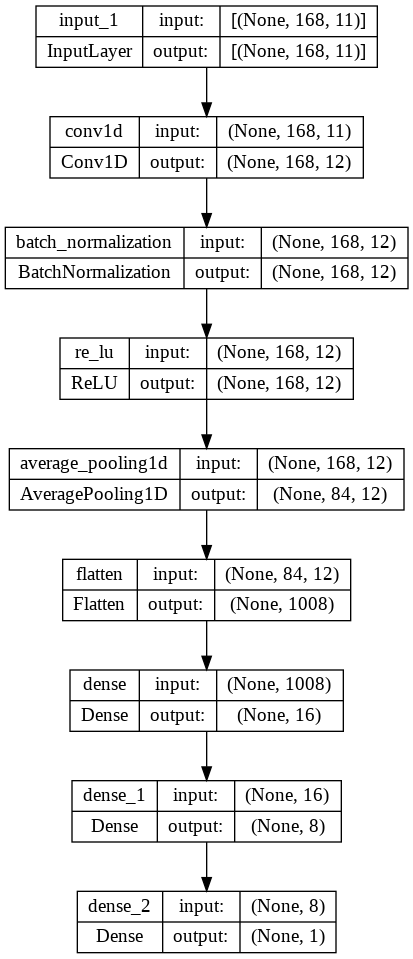

In [ ]:
# Main model
model_main = make_model(input_shape=XTrain_ts.shape[1:])
keras.utils.plot_model(model_main, show_shapes=True)

In [ ]:
epochs = 5
batch_size = 256

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model_main.compile(
    optimizer="adam",
    loss="mse",
    metrics=['mae'],
    run_eagerly=True
)
history = model_main.fit(
    np.asarray(XTrain_ts).astype(np.float64),
    np.asarray(yTrain['PM25']).astype(np.float64),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/5
109/109 [==============================] - 15s 138ms/step - loss: 97.2803 - mae: 6.8829 - val_loss: 101.0996 - val_mae: 6.9515 - lr: 0.0010
Epoch 2/5
109/109 [==============================] - 15s 139ms/step - loss: 58.6886 - mae: 5.2087 - val_loss: 91.2142 - val_mae: 6.5658 - lr: 0.0010
Epoch 3/5
109/109 [==============================] - 15s 135ms/step - loss: 53.1326 - mae: 4.9185 - val_loss: 97.5216 - val_mae: 6.7856 - lr: 0.0010
Epoch 4/5
109/109 [==============================] - 15s 141ms/step - loss: 50.2688 - mae: 4.7623 - val_loss: 78.6866 - val_mae: 6.1012 - lr: 0.0010
Epoch 5/5
109/109 [==============================] - 15s 133ms/step - loss: 48.5676 - mae: 4.6997 - val_loss: 80.9072 - val_mae: 6.0891 - lr: 0.0010


In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

y_hat = model_main.predict(XTest_ts)

print('R2_score: ' + str(r2_score(np.array(yTest['PM25']), y_hat)))
print('MSE: ' + str(mean_squared_error(np.array(yTest['PM25']), y_hat)))
print('MAE: ' + str(mean_absolute_error(np.array(yTest['PM25']), y_hat)))

268/268 [==============================] - 3s 10ms/step
R2_score: 0.38691738021556177
MSE: 70.66503504582435
MAE: 5.5372014459531735


Text(0, 0.5, 'Prediction')

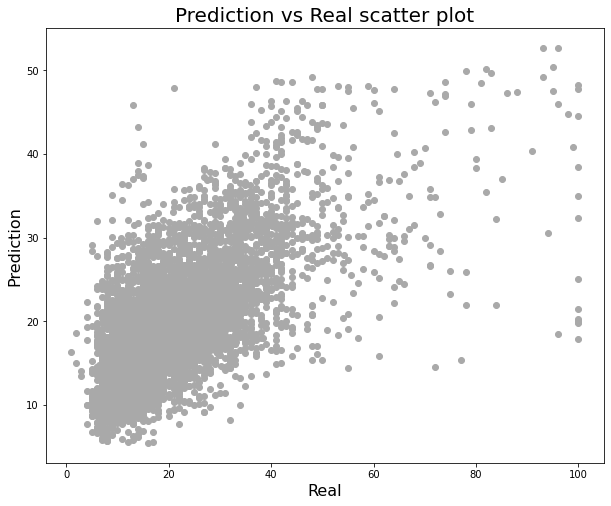

In [ ]:
plt.rcParams["figure.figsize"] = (10,8)
plt.scatter(yTest['PM25'], y_hat, c='darkgrey')
plt.title('Prediction vs Real scatter plot', fontsize=20)
plt.xlabel('Real', fontsize=16)
plt.ylabel('Prediction', fontsize=16)

In [ ]:
df = pd.DataFrame(yTest['PM25'])
df['yhat'] = pd.DataFrame(y_hat)
df['diff'] = abs(df['PM25']-df['yhat'])
df['rnd'] = np.round(df['PM25'], -1)

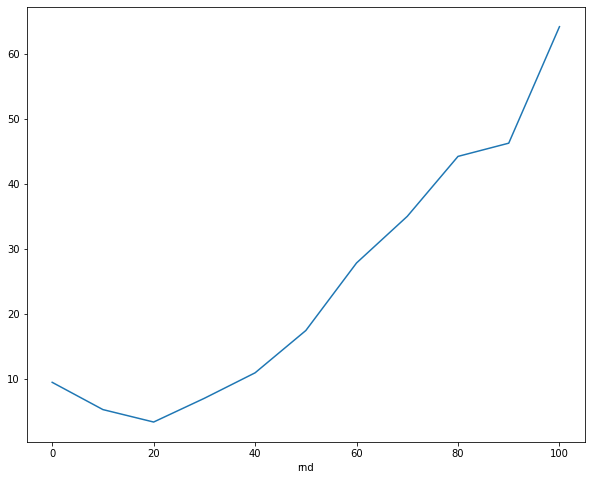

In [ ]:
df.groupby('rnd').mean()['diff'].plot.line()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


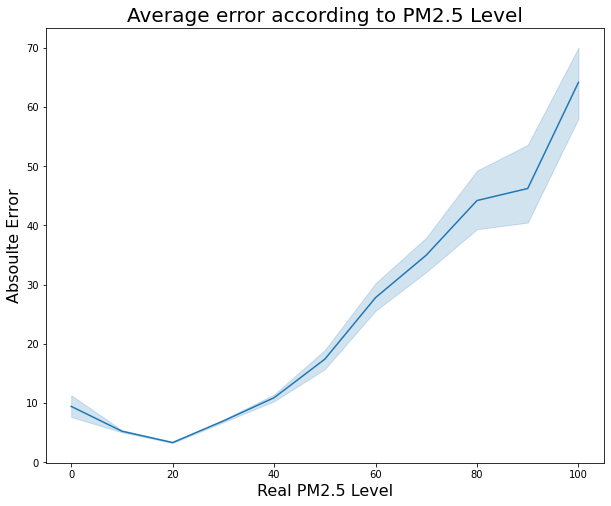

In [ ]:
import seaborn as sns

df_grp = df.groupby('rnd').mean()['diff']
x = df['rnd']
y = df['diff']

plt.xlabel('Real PM2.5 Level', fontsize=16)
plt.ylabel('Absoulte Error', fontsize=16)
plt.title('Average error according to PM2.5 Level', fontsize=20)
sns.lineplot(x, y)

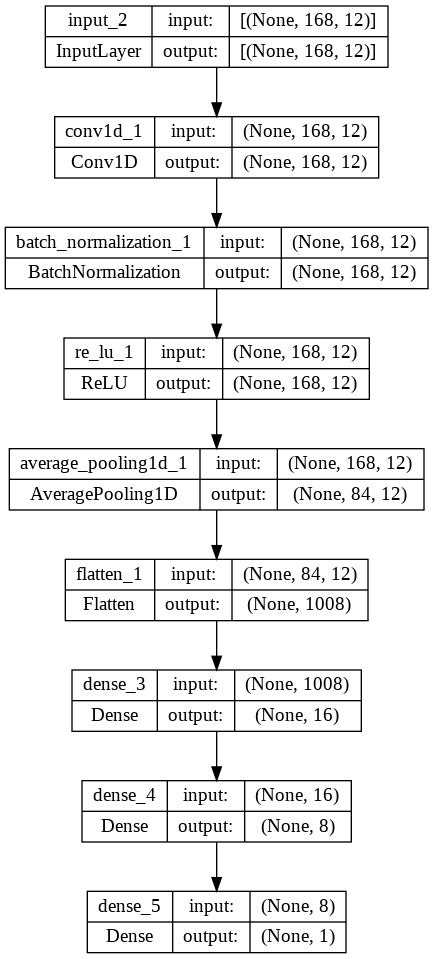

In [ ]:
# Base model2
model_base2 = make_model(input_shape=XTrain_PM25_ts.shape[1:])
keras.utils.plot_model(model_base2, show_shapes=True)

In [ ]:
epochs = 5
batch_size = 256

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model_base2.compile(
    optimizer="adam",
    loss="mse",
    metrics=['mae'],
    run_eagerly=True
)
history = model_base2.fit(
    np.asarray(XTrain_PM25_ts).astype(np.float64),
    np.asarray(yTrain['PM25']).astype(np.float64),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/5
109/109 [==============================] - 18s 161ms/step - loss: 90.2282 - mae: 6.5692 - val_loss: 91.2471 - val_mae: 6.5860 - lr: 0.0010
Epoch 2/5
109/109 [==============================] - 16s 144ms/step - loss: 54.7260 - mae: 4.9943 - val_loss: 82.4651 - val_mae: 6.2121 - lr: 0.0010
Epoch 3/5
109/109 [==============================] - 15s 137ms/step - loss: 50.2633 - mae: 4.7442 - val_loss: 76.0589 - val_mae: 5.9952 - lr: 0.0010
Epoch 4/5
109/109 [==============================] - 16s 146ms/step - loss: 47.2432 - mae: 4.6021 - val_loss: 87.5285 - val_mae: 6.4316 - lr: 0.0010
Epoch 5/5
109/109 [==============================] - 15s 137ms/step - loss: 46.0896 - mae: 4.5728 - val_loss: 68.1402 - val_mae: 5.6496 - lr: 0.0010


In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

y_hat = model_base2.predict(XTest_PM25_ts)

print('R2_score: ' + str(r2_score(np.array(yTest['PM25']), y_hat)))
print('MSE: ' + str(mean_squared_error(np.array(yTest['PM25']), y_hat)))
print('MAE: ' + str(mean_absolute_error(np.array(yTest['PM25']), y_hat)))

268/268 [==============================] - 3s 10ms/step
R2_score: 0.4667880444913204
MSE: 61.45899476994078
MAE: 5.331213828259391


In [ ]:
def cal_p(y_hat, y_true):
  return 1-np.sum(abs(y_hat-y_true))/np.sum(y_true)


fin = pd.DataFrame.from_dict({'MSE': [mean_squared_error(np.array(yTest['PM25']), model_main.predict(XTest_ts))
                                      ,mean_squared_error(np.array(yTest['PM25']), model_base2.predict(XTest_PM25_ts))],
                              'MAE': [mean_absolute_error(np.array(yTest['PM25']), model_main.predict(XTest_ts))
                                     ,mean_absolute_error(np.array(yTest['PM25']), model_base2.predict(XTest_PM25_ts))],
                              'P': [cal_p(np.array(yTest['PM25']), model_main.predict(XTest_ts).reshape(-1))
                                    ,cal_p(np.array(yTest['PM25']), model_base2.predict(XTest_PM25_ts).reshape(-1))]})
fin

268/268 [==============================] - 3s 9ms/step


,MSE,MAE,P
0,70.665035,5.537201,0.722931
1,61.458995,5.331214,0.732436


In [ ]:
# set height of bar
MSE_M = [mean_squared_error(np.array(yTest['PM25']), model_main.predict(XTest_ts))]
MSE_B = [mean_squared_error(np.array(yTest['PM25']), model_base2.predict(XTest_PM25_ts))]

MAE_M = [mean_absolute_error(np.array(yTest['PM25']), model_main.predict(XTest_ts))]
MAE_B = [mean_absolute_error(np.array(yTest['PM25']), model_base2.predict(XTest_PM25_ts))]

P_M = [cal_p(np.array(yTest['PM25']), model_main.predict(XTest_ts).reshape(-1))]
P_B = [cal_p(np.array(yTest['PM25']), model_base2.predict(XTest_PM25_ts).reshape(-1))]

268/268 [==============================] - 2s 9ms/step


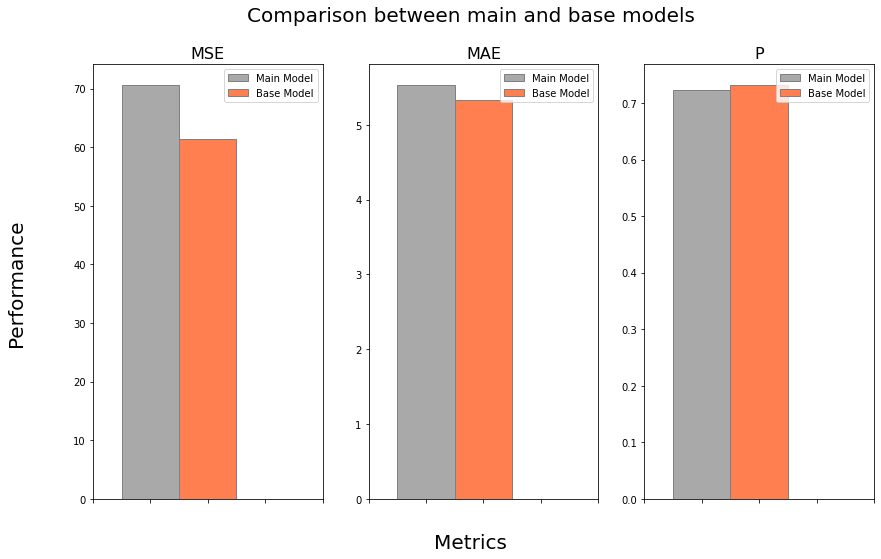

In [ ]:
# Set position of bar on X axis
# creating the dataset
# set width of bar
barWidth = 0.05

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize =(14, 8))

br1 = np.arange(len(MSE_M))
br2 = [x + barWidth for x in br1]

# Make the plot
ax1.bar(br1, MSE_M, color ='darkgrey', width = barWidth,
        edgecolor ='grey', label ='Main Model')
ax1.bar(br2, MSE_B, color ='coral', width = barWidth,
        edgecolor ='grey', label ='Base Model')
ax1.set_xlim(-0.05, 0.15)
ax1.set_xticklabels([])


ax2.bar(br1, MAE_M, color ='darkgrey', width = barWidth,
        edgecolor ='grey', label ='Main Model')
ax2.bar(br2, MAE_B, color ='coral', width = barWidth,
        edgecolor ='grey', label ='Base Model')
ax2.set_xlim(-0.05, 0.15)
ax2.set_xticklabels([])

ax3.bar(br1, P_M, color ='darkgrey', width = barWidth,
        edgecolor ='grey', label ='Main Model')
ax3.bar(br2, P_B, color ='coral', width = barWidth,
        edgecolor ='grey', label ='Base Model')
ax3.set_xlim(-0.05, 0.15)
ax3.set_xticklabels([])

# Adding Xticks
fig.suptitle('Comparison between main and base models', fontsize=20)
ax1.set_title('MSE', fontsize=16)
ax1.legend()

ax2.set_title('MAE', fontsize=16)
ax2.legend()

ax3.set_title('P', fontsize=16)
ax3.legend()

fig.text(0.5, 0.04, 'Metrics', fontsize=20, ha='center')
fig.text(0.04, 0.5, 'Performance', fontsize=20 , va='center', rotation='vertical')

plt.show()

In [ ]:
pd.DataFrame.from_dict({'MSE': [24.0]})

,MSE
0,24.0


In [ ]:
r2_score(np.array(yTest['PM25'][5:]), yTest['PM25'][:-5])

0.29720540011500984

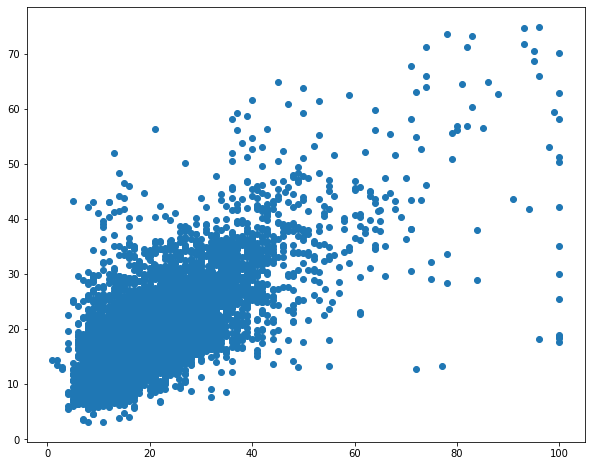

In [ ]:
plt.scatter(yTest['PM25'], y_hat)

In [ ]:
# https://www.nature.com/articles/s41598-021-91253-9.pdf?origin=ppub

In [ ]:
inputs = keras.layers.Input(shape=(XTrain_ts.shape[1], XTrain_ts.shape[2]))
lstm1 = keras.layers.LSTM(64)(inputs)
dense1 = keras.layers.Dense(16)(lstm1)
dense2 = keras.layers.Dense(8)(dense1)
outputs = keras.layers.Dense(1)(dense2)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 168, 11)]         0         
                                                                 
 lstm (LSTM)                 (None, 64)                19456     
                                                                 
 dense_6 (Dense)             (None, 16)                1040      
                                                                 
 dense_7 (Dense)             (None, 8)                 136       
                                                                 
 dense_8 (Dense)             (None, 1)                 9         
                                                                 
Total params: 20,641
Trainable params: 20,641
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]

epochs=5
batch_size = 256

history = model.fit(
    np.asarray(XTrain_ts).astype(np.float64),
    np.asarray(yTrain['PM25']).astype(np.float64),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/5
109/109 [==============================] - 44s 386ms/step - loss: 166.9427 - val_loss: 110.6034 - lr: 0.0010
Epoch 2/5
109/109 [==============================] - 41s 380ms/step - loss: 67.9846 - val_loss: 97.7657 - lr: 0.0010
Epoch 3/5
109/109 [==============================] - 41s 378ms/step - loss: 59.3659 - val_loss: 90.2364 - lr: 0.0010
Epoch 4/5
109/109 [==============================] - 44s 403ms/step - loss: 54.8392 - val_loss: 83.1521 - lr: 0.0010
Epoch 5/5
109/109 [==============================] - 41s 377ms/step - loss: 51.5927 - val_loss: 84.6221 - lr: 0.0010


In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

y_hat = model.predict(XTest_ts)

print('R2_score: ' + str(r2_score(np.array(yTest['PM25']), y_hat)))
print('MSE: ' + str(mean_squared_error(np.array(yTest['PM25']), y_hat)))
print('MAE: ' + str(mean_absolute_error(np.array(yTest['PM25']), y_hat)))

268/268 [==============================] - 7s 23ms/step
R2_score: 0.34478662386115866
MSE: 75.52110383364575
MAE: 5.629537011376061


In [ ]:
cal_p(np.array(yTest['PM25']), model.predict(XTest_ts).reshape(-1))

268/268 [==============================] - 7s 25ms/step


0.7011235571470875

In [ ]:
inputs = keras.layers.Input(shape=(XTrain_PM25_ts.shape[1], XTrain_PM25_ts.shape[2]))
lstm1 = keras.layers.LSTM(64)(inputs)
dense1 = keras.layers.Dense(16, activation='relu')(lstm1)
dense2 = keras.layers.Dense(8, activation='relu')(dense1)
outputs = keras.layers.Dense(1)(dense2)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 168, 12)]         0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                19712     
                                                                 
 dense_9 (Dense)             (None, 16)                1040      
                                                                 
 dense_10 (Dense)            (None, 8)                 136       
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 20,897
Trainable params: 20,897
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]

epochs=5
batch_size = 256

history = model.fit(
    np.asarray(XTrain_PM25_ts).astype(np.float64),
    np.asarray(yTrain['PM25']).astype(np.float64),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/5
109/109 [==============================] - 49s 420ms/step - loss: 256.0442 - val_loss: 141.3271 - lr: 0.0010
Epoch 2/5
109/109 [==============================] - 42s 386ms/step - loss: 91.1545 - val_loss: 108.8164 - lr: 0.0010
Epoch 3/5
109/109 [==============================] - 42s 382ms/step - loss: 65.1213 - val_loss: 84.7484 - lr: 0.0010
Epoch 4/5
109/109 [==============================] - 44s 405ms/step - loss: 56.5446 - val_loss: 73.4096 - lr: 0.0010
Epoch 5/5
109/109 [==============================] - 42s 385ms/step - loss: 52.8717 - val_loss: 70.0825 - lr: 0.0010


In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

y_hat = model.predict(XTest_PM25_ts)

print('R2_score: ' + str(r2_score(np.array(yTest['PM25']), y_hat)))
print('MSE: ' + str(mean_squared_error(np.array(yTest['PM25']), y_hat)))
print('MAE: ' + str(mean_absolute_error(np.array(yTest['PM25']), y_hat)))

268/268 [==============================] - 7s 25ms/step
R2_score: 0.43232211350353245
MSE: 65.43160163000043
MAE: 5.318392705134716


In [ ]:
cal_p(np.array(yTest['PM25']), model.predict(XTest_PM25_ts).reshape(-1))

268/268 [==============================] - 7s 25ms/step


0.733434784407819

In [ ]:
(s1, s2, s3) = XTrain_ts.shape
XTrain_tree = XTrain_ts.reshape((s1, s2*s3))

(s1, s2, s3) = XTrain_PM25_ts.shape
XTrain_PM25_tree = XTrain_PM25_ts.reshape((s1, s2*s3))

(s1, s2, s3) = XTest_ts.shape
XTest_tree = XTest_ts.reshape((s1, s2*s3))

(s1, s2, s3) = XTest_PM25_ts.shape
XTest_PM25_tree = XTest_PM25_ts.reshape((s1, s2*s3))

print('XTrain: ' + str(XTrain_tree.shape))
print('XTrain_PM25: ' + str(XTrain_PM25_tree.shape))
print('XTest: ' + str(XTest_tree.shape))
print('XTest_PM25: ' + str(XTest_PM25_tree.shape))

XTrain: (34723, 1848)
XTrain_PM25: (34723, 2016)
XTest: (8563, 1848)
XTest_PM25: (8563, 2016)


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=150)
pca.fit(XTrain_tree)
XTrain_tree = pca.transform(XTrain_tree)
XTest_tree = pca.transform(XTest_tree)

pca_PM25 = PCA(n_components=150)
pca_PM25.fit(XTrain_PM25_tree)
XTrain_PM25_tree = pca_PM25.transform(XTrain_PM25_tree)
XTest_PM25_tree = pca_PM25.transform(XTest_PM25_tree)

In [ ]:
print('XTrain: ' + str(XTrain_tree.shape))
print('XTrain_PM25: ' + str(XTrain_PM25_tree.shape))
print('XTest: ' + str(XTest_tree.shape))
print('XTest_PM25: ' + str(XTest_PM25_tree.shape))

XTrain: (34723, 150)
XTrain_PM25: (34723, 150)
XTest: (8563, 150)
XTest_PM25: (8563, 150)


In [ ]:
import xgboost
from xgboost import XGBRegressor

model = XGBRegressor()
model.fit(XTrain_tree, yTrain['PM25'])

[00:36:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

y_hat = model.predict(XTest_tree)

print('R2_score: ' + str(r2_score(np.array(yTest['PM25']), y_hat)))
print('MSE: ' + str(mean_squared_error(np.array(yTest['PM25']), y_hat)))
print('MAE: ' + str(mean_absolute_error(np.array(yTest['PM25']), y_hat)))

R2_score: 0.280684291282713
MSE: 82.90965707589496
MAE: 6.088749793992893


In [ ]:
cal_p(np.array(yTest['PM25']), model.predict(XTest_tree).reshape(-1))

0.6837455566588261

In [ ]:
import xgboost
from xgboost import XGBRegressor

model = XGBRegressor()
model.fit(XTrain_PM25_tree, yTrain['PM25'])

[00:37:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

y_hat = model.predict(XTest_PM25_tree)

print('R2_score: ' + str(r2_score(np.array(yTest['PM25']), y_hat)))
print('MSE: ' + str(mean_squared_error(np.array(yTest['PM25']), y_hat)))
print('MAE: ' + str(mean_absolute_error(np.array(yTest['PM25']), y_hat)))

R2_score: 0.3529636095974633
MSE: 74.57860935577531
MAE: 5.891751112819992


In [ ]:
cal_p(np.array(yTest['PM25']), model.predict(XTest_tree).reshape(-1))

0.6306573824814841

In [ ]:
# https://www.nature.com/articles/s41598-020-77757-w